In [11]:
"""
PREPROCESAMIENTO PARA ML
Manejo de missing, encoding, split train/test
"""

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("PREPROCESAMIENTO PARA MODELADO ML")
print("="*80)

# =============================================================================
# PASO 1: CARGAR DATASET
# =============================================================================

print("\n[1/7] Cargando dataset limpio...")

df = pd.read_csv('FUSION EMICRON 2024 + GEIH 2023/dataset_ml_clean2.csv')

print(f"  Dimensiones: {df.shape}")
print(f"  Micronegocios: {df.shape[0]:,}")
print(f"  Features: {df.shape[1]}")

# =============================================================================
# PASO 2: IDENTIFICAR VARIABLE OBJETIVO
# =============================================================================

print("\n[2/7] Identificando variable objetivo...")

# Buscar variables objetivo
vars_objetivo = [c for c in df.columns if 'exito' in c.lower()]

if not vars_objetivo:
    print("  No se encontró variable objetivo, creando una...")
    
    # Crear variable objetivo: éxito basado en ingresos
    if 'ingresos_totales_declarados' in df.columns:
        # Comparar con mediana por sector
        if 'sector_economico' in df.columns:
            df['mediana_sector'] = df.groupby('sector_economico')['ingresos_totales_declarados'].transform('median')
            df['exito'] = (df['ingresos_totales_declarados'] > df['mediana_sector']).astype(int)
            print("  ✓ Variable 'exito' creada (ingresos > mediana del sector)")
        else:
            # Comparar con mediana general
            mediana = df['ingresos_totales_declarados'].median()
            df['exito'] = (df['ingresos_totales_declarados'] > mediana).astype(int)
            print("   Variable 'exito' creada (ingresos > mediana general)")
        
        target_col = 'exito'
    else:
        print("   ERROR: No hay columna de ingresos para crear objetivo")
        exit(1)
else:
    # Usar la primera variable objetivo encontrada
    target_col = vars_objetivo[0]
    print(f"  Variable objetivo: {target_col}")

# Verificar distribución
if target_col in df.columns:
    print(f"\n  Distribución de {target_col}:")
    print(df[target_col].value_counts())
    balance = df[target_col].mean() * 100
    print(f"  Balance: {balance:.1f}% clase 1 / {100-balance:.1f}% clase 0")

# =============================================================================
# PASO 3: SEPARAR FEATURES Y TARGET
# =============================================================================

print("\n[3/7] Separando features y target...")

# Columnas a excluir de features
cols_excluir = [target_col, 'id_micronegocio']
if 'mediana_sector' in df.columns:
    cols_excluir.append('mediana_sector')

# Identificar columnas de features
feature_cols = [c for c in df.columns if c not in cols_excluir]

X = df[feature_cols].copy()
y = df[target_col].copy()

print(f"  Features: {X.shape[1]}")
print(f"  Target: {y.shape[0]:,} valores")

# =============================================================================
# PASO 4: ANALIZAR Y MANEJAR DATOS FALTANTES
# =============================================================================

print("\n[4/7] Manejando datos faltantes...")

# Reporte de missing
missing = X.isnull().sum()
missing_pct = (missing / len(X)) * 100
missing_df = pd.DataFrame({
    'columna': missing.index,
    'missing': missing.values,
    'porcentaje': missing_pct.values
}).sort_values('porcentaje', ascending=False)

missing_df = missing_df[missing_df['missing'] > 0]

if len(missing_df) > 0:
    print(f"\n  Columnas con missing: {len(missing_df)}")
    print(f"\n  Top 10:")
    for idx, row in missing_df.head(10).iterrows():
        print(f"    {row['columna']:40s}: {row['missing']:8.0f} ({row['porcentaje']:5.1f}%)")
    
    # ESTRATEGIA DE IMPUTACIÓN
    print(f"\n  Aplicando imputación...")
    
    # 1. Numéricas: mediana
    num_cols = X.select_dtypes(include=[np.number]).columns
    for col in num_cols:
        if X[col].isnull().sum() > 0:
            median_val = X[col].median()
            X[col] = X[col].fillna(median_val)
    
    # 2. Categóricas: moda o 'Desconocido'
    cat_cols = X.select_dtypes(include=['object', 'category']).columns
    for col in cat_cols:
        if X[col].isnull().sum() > 0:
            if X[col].mode().shape[0] > 0:
                X[col] = X[col].fillna(X[col].mode()[0])
            else:
                X[col] = X[col].fillna('Desconocido')
    
    missing_after = X.isnull().sum().sum()
    print(f"  Missing antes: {missing.sum():,}")
    print(f"  Missing después: {missing_after:,}")
else:
    print("  No hay valores faltantes")

# =============================================================================
# PASO 5: CODIFICAR VARIABLES CATEGORICAS
# =============================================================================

print("\n[5/7] Codificando variables categóricas...")

# Identificar categóricas
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

if len(cat_cols) > 0:
    print(f"  Variables categóricas: {len(cat_cols)}")
    
    # LightGBM maneja categóricas nativamente, pero necesitan ser tipo 'category'
    for col in cat_cols:
        if X[col].dtype == 'object':
            X[col] = X[col].astype('category')
        
        # Imprimir info
        n_unique = X[col].nunique()
        print(f"    {col:40s}: {n_unique:4d} categorías")
    
    print(f"  Variables convertidas a tipo 'category'")
else:
    print("   No hay variables categóricas")

# =============================================================================
# PASO 6: DETECTAR Y MANEJAR OUTLIERS
# =============================================================================

print("\n[6/7] Detectando outliers extremos...")

# Solo en variables numéricas clave
num_cols = X.select_dtypes(include=[np.number]).columns

outliers_detectados = []
for col in num_cols:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Outliers extremos (más allá de 3*IQR)
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    
    outliers = ((X[col] < lower_bound) | (X[col] > upper_bound)).sum()
    
    if outliers > 0:
        pct = outliers / len(X) * 100
        if pct > 1:  # Solo mostrar si >1%
            outliers_detectados.append((col, outliers, pct))

if outliers_detectados:
    print(f"  Columnas con outliers extremos (>1%):")
    for col, count, pct in sorted(outliers_detectados, key=lambda x: x[2], reverse=True)[:10]:
        print(f"    {col:40s}: {count:6,} ({pct:5.1f}%)")
    
    print(f"\n  Nota: LightGBM es robusto ante outliers, no se eliminan")
else:
    print("  No se detectaron outliers extremos significativos")

# =============================================================================
# PASO 7: TRAIN/TEST SPLIT
# =============================================================================

print("\n[7/7] Creando train/test split...")

# Split estratificado (mantiene proporción de clases)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"  Train: {X_train.shape[0]:,} muestras ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Test:  {X_test.shape[0]:,} muestras ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\n  Balance en Train:")
print(f"    Clase 0: {(y_train==0).sum():,} ({(y_train==0).sum()/len(y_train)*100:.1f}%)")
print(f"    Clase 1: {(y_train==1).sum():,} ({(y_train==1).sum()/len(y_train)*100:.1f}%)")

print(f"\n  Balance en Test:")
print(f"    Clase 0: {(y_test==0).sum():,} ({(y_test==0).sum()/len(y_test)*100:.1f}%)")
print(f"    Clase 1: {(y_test==1).sum():,} ({(y_test==1).sum()/len(y_test)*100:.1f}%)")

# =============================================================================
# GUARDAR DATASETS PROCESADOS
# =============================================================================

print("\n" + "="*80)
print("GUARDANDO DATASETS PROCESADOS")
print("="*80)

# Guardar train
train_df = X_train.copy()
train_df[target_col] = y_train
train_df.to_csv('PROCESAMIENTO/train.csv', index=False)
print(f"  train.csv: {train_df.shape}")

# Guardar test
test_df = X_test.copy()
test_df[target_col] = y_test
test_df.to_csv('PROCESAMIENTO/test.csv', index=False)
print(f"  test.csv: {test_df.shape}")

# Guardar info de features
feature_info = pd.DataFrame({
    'feature': X.columns,
    'dtype': X.dtypes.values,
    'missing_pct': (X.isnull().sum() / len(X) * 100).values,
    'nunique': [X[col].nunique() for col in X.columns]
})
feature_info.to_csv('PROCESAMIENTO/feature_info.csv', index=False)
print(f"  feature_info.csv")

# =============================================================================
# RESUMEN FINAL
# =============================================================================

print("\n" + "="*80)
print("RESUMEN FINAL")
print("="*80)

print(f"""
Dataset original:
  Filas: {df.shape[0]:,}
  Columnas: {df.shape[1]}

Dataset procesado:
  Features: {X.shape[1]}
  Target: {target_col}
  
Train/Test split:
  Train: {X_train.shape[0]:,} ({X_train.shape[0]/len(X)*100:.1f}%)
  Test:  {X_test.shape[0]:,} ({X_test.shape[0]/len(X)*100:.1f}%)
  
Tipos de features:
  Numéricas: {len(X.select_dtypes(include=[np.number]).columns)}
  Categóricas: {len(X.select_dtypes(include=['category']).columns)}
  
Missing values: {X.isnull().sum().sum()} (todos imputados ✓)

Balance de clases:
  Train: {(y_train==1).sum()/len(y_train)*100:.1f}% / {(y_train==0).sum()/len(y_train)*100:.1f}%
  Test:  {(y_test==1).sum()/len(y_test)*100:.1f}% / {(y_test==0).sum()/len(y_test)*100:.1f}%
""")

print("="*80)
print("PREPROCESAMIENTO COMPLETADO")
print("="*80)
print("\nArchivos generados:")
print("  - train.csv (para entrenar)")
print("  - test.csv (para evaluar)")
print("  - feature_info.csv (metadata)")
print("\nSiguiente paso:")
print("  → python 03_modelo_baseline.py")
print("="*80)

PREPROCESAMIENTO PARA MODELADO ML

[1/7] Cargando dataset limpio...
  Dimensiones: (68702, 195)
  Micronegocios: 68,702
  Features: 195

[2/7] Identificando variable objetivo...
  Variable objetivo: exito_ingresos

  Distribución de exito_ingresos:
exito_ingresos
0    51601
1    17101
Name: count, dtype: int64
  Balance: 24.9% clase 1 / 75.1% clase 0

[3/7] Separando features y target...
  Features: 193
  Target: 68,702 valores

[4/7] Manejando datos faltantes...

  Columnas con missing: 16

  Top 10:
    numero_trabajadores                     :    55824 ( 81.3%)
    trabajadores_familiares                 :    55824 ( 81.3%)
    trabajadores_no_familiares              :    55824 ( 81.3%)
    trabajadores_permanentes                :    55824 ( 81.3%)
    trabajadores_temporales                 :    55824 ( 81.3%)
    trabajadores_remunerados                :    55824 ( 81.3%)
    trabajadores_no_remunerados             :    55824 ( 81.3%)
    trabajadores_mujeres                    :

In [3]:
#!/usr/bin/env python3
"""
CORREGIR VARIABLE OBJETIVO
Recalcular exito_ingresos correctamente
"""

import pandas as pd
import numpy as np

print("="*80)
print("CORRIGIENDO VARIABLE OBJETIVO")
print("="*80)

# =============================================================================
# CARGAR DATASET
# =============================================================================

print("\n[1/4] Cargando dataset...")
df = pd.read_csv('output_fusion/dataset_ml_clean.csv')
print(f"  Dimensiones: {df.shape}")

# =============================================================================
# VERIFICAR PROBLEMA
# =============================================================================

print("\n[2/4] Verificando variable objetivo actual...")

if 'exito_ingresos' in df.columns:
    print(f"  Variable 'exito_ingresos' encontrada")
    print(f"  Distribución:")
    print(df['exito_ingresos'].value_counts())
    print(f"  Balance: {df['exito_ingresos'].mean()*100:.1f}% éxito")
    
    if df['exito_ingresos'].sum() == 0:
        print(f"  PROBLEMA: Todos son clase 0 (100% fracaso)")
        print(f"  Eliminando variable incorrecta...")
        df = df.drop('exito_ingresos', axis=1)

# Verificar si hay otras variables objetivo
otras_objetivo = [c for c in df.columns if 'exito' in c.lower()]
if otras_objetivo:
    print(f"\n  Otras variables objetivo encontradas: {otras_objetivo}")
    for var in otras_objetivo:
        if var != 'exito_ingresos':
            print(f"    {var}: {df[var].value_counts().to_dict()}")

# =============================================================================
# RECALCULAR VARIABLE OBJETIVO
# =============================================================================

print("\n[3/4] Recalculando variable objetivo...")

# OPCIÓN 1: Por ingresos (comparar con mediana del sector)
if 'ingresos_totales_declarados' in df.columns:
    print(f"\n  Usando: ingresos_totales_declarados")
    
    # Convertir a numérico
    df['ingresos_totales_declarados'] = pd.to_numeric(df['ingresos_totales_declarados'], errors='coerce')
    
    # Ver estadísticas
    print(f"  Estadísticas de ingresos:")
    print(f"    Min: ${df['ingresos_totales_declarados'].min():,.0f}")
    print(f"    Q25: ${df['ingresos_totales_declarados'].quantile(0.25):,.0f}")
    print(f"    Mediana: ${df['ingresos_totales_declarados'].median():,.0f}")
    print(f"    Q75: ${df['ingresos_totales_declarados'].quantile(0.75):,.0f}")
    print(f"    Max: ${df['ingresos_totales_declarados'].max():,.0f}")
    
    # Estrategia 1: Comparar con mediana del sector (si existe sector)
    if 'sector_economico' in df.columns:
        print(f"\n  Estrategia: Comparar con mediana del sector")
        df['mediana_sector'] = df.groupby('sector_economico')['ingresos_totales_declarados'].transform('median')
        df['exito_ingresos'] = (df['ingresos_totales_declarados'] > df['mediana_sector']).astype(int)
        
        # Mostrar medianas por sector
        print(f"\n  Medianas por sector:")
        medianas = df.groupby('sector_economico')['ingresos_totales_declarados'].median().sort_values(ascending=False)
        for sector, mediana in medianas.head(10).items():
            print(f"    {sector:40s}: ${mediana:,.0f}")
        
        # Eliminar columna auxiliar
        df = df.drop('mediana_sector', axis=1)
    else:
        print(f"\n  Estrategia: Comparar con mediana global")
        mediana_global = df['ingresos_totales_declarados'].median()
        df['exito_ingresos'] = (df['ingresos_totales_declarados'] > mediana_global).astype(int)
        print(f"  Mediana global: ${mediana_global:,.0f}")
    
    # Verificar resultado
    print(f"\n  Nueva distribución:")
    print(df['exito_ingresos'].value_counts())
    balance = df['exito_ingresos'].mean() * 100
    print(f"  Balance: {balance:.1f}% éxito / {100-balance:.1f}% fracaso")
    
    if df['exito_ingresos'].sum() == 0:
        print(f"\n  ⚠️ SIGUE SIENDO PROBLEMA!")
        print(f"  Causa probable: Todos los ingresos son iguales a la mediana")
        
        # Alternativa: Usar cuartiles
        print(f"\n  Alternativa: Usar Q75 como umbral")
        q75 = df['ingresos_totales_declarados'].quantile(0.75)
        df['exito_ingresos'] = (df['ingresos_totales_declarados'] > q75).astype(int)
        
        print(f"  Q75: ${q75:,.0f}")
        print(f"  Nueva distribución:")
        print(df['exito_ingresos'].value_counts())
        balance = df['exito_ingresos'].mean() * 100
        print(f"  Balance: {balance:.1f}% éxito / {100-balance:.1f}% fracaso")

elif 'indice_exito' in df.columns:
    print(f"\n  Usando: indice_exito")
    df['indice_exito'] = pd.to_numeric(df['indice_exito'], errors='coerce')
    df['exito_ingresos'] = (df['indice_exito'] > 50).astype(int)
    
    print(f"  Nueva distribución:")
    print(df['exito_ingresos'].value_counts())
    balance = df['exito_ingresos'].mean() * 100
    print(f"  Balance: {balance:.1f}% éxito / {100-balance:.1f}% fracaso")

else:
    print(f"  ✗ ERROR: No hay variable para calcular objetivo")
    print(f"  Columnas disponibles con 'ingreso':")
    cols_ingreso = [c for c in df.columns if 'ingreso' in c.lower()]
    for col in cols_ingreso:
        print(f"    - {col}")

# =============================================================================
# GUARDAR DATASET CORREGIDO
# =============================================================================

print("\n[4/4] Guardando dataset corregido...")

if 'exito_ingresos' in df.columns and df['exito_ingresos'].sum() > 0:
    df.to_csv('output_fusion/dataset_ml_clean_fixed.csv', index=False)
    print(f"  ✓ Guardado: dataset_ml_clean_fixed.csv")
    print(f"  Dimensiones: {df.shape}")
    print(f"  Variable objetivo OK: {df['exito_ingresos'].sum():,} éxitos")
    
    print("\n" + "="*80)
    print("✅ VARIABLE OBJETIVO CORREGIDA")
    print("="*80)
    print(f"\nAhora ejecuta:")
    print(f"  1. Renombrar dataset:")
    print(f"     mv output_fusion/dataset_ml_clean_fixed.csv output_fusion/dataset_ml_clean.csv")
    print(f"  2. Re-ejecutar preprocesamiento:")
    print(f"     python 01_preprocesamiento.py")
else:
    print(f"\n  ✗ ERROR: No se pudo corregir la variable objetivo")
    print(f"  Necesitas revisar manualmente qué variable usar")

print("="*80)

CORRIGIENDO VARIABLE OBJETIVO

[1/4] Cargando dataset...
  Dimensiones: (68702, 196)

[2/4] Verificando variable objetivo actual...
  Variable 'exito_ingresos' encontrada
  Distribución:
exito_ingresos
0    68702
Name: count, dtype: int64
  Balance: 0.0% éxito
  PROBLEMA: Todos son clase 0 (100% fracaso)
  Eliminando variable incorrecta...

  Otras variables objetivo encontradas: ['exito_compuesto', 'indice_exito']
    exito_compuesto: {0: 51601, 1: 17101}
    indice_exito: {45.0: 26373, 52.5: 16603, 40.0: 9577, 32.5: 5256, 35.0: 3201, 47.5: 1653, 33.75: 1184, 28.749999999999996: 834, 22.5: 570, 41.25: 506, 26.25: 476, 53.75: 372, 36.25: 363, 46.25: 322, 27.500000000000004: 292, 38.75: 165, 30.0: 160, 23.75: 142, 48.75: 132, 51.24999999999999: 94, 21.25: 82, 42.5: 62, 25.0: 62, 20.0: 55, 37.5: 43, 31.25: 26, 43.75: 14, 55.00000000000001: 12, 15.0: 8, 50.0: 6, 49.09090909090909: 3, 39.54545454545455: 2, 50.68181818181819: 2, 46.13636363636363: 2, 56.13636363636364: 2, 48.63636363636364:

ValueError: Unknown format code 's' for object of type 'float'

In [7]:
#!/usr/bin/env python3
"""
CORREGIR VARIABLE OBJETIVO
Recalcular exito_ingresos correctamente
"""

import pandas as pd
import numpy as np

print("="*80)
print("CORRIGIENDO VARIABLE OBJETIVO")
print("="*80)

# =============================================================================
# CARGAR DATASET
# =============================================================================

print("\n[1/4] Cargando dataset...")
df = pd.read_csv('FUSION EMICRON 2024 + GEIH 2023/dataset_ml_clean.csv')
print(f"  Dimensiones: {df.shape}")

# =============================================================================
# VERIFICAR PROBLEMA
# =============================================================================

print("\n[2/4] Verificando variable objetivo actual...")

if 'exito_ingresos' in df.columns:
    print(f"  Variable 'exito_ingresos' encontrada")
    print(f"  Distribución:")
    print(df['exito_ingresos'].value_counts())
    print(f"  Balance: {df['exito_ingresos'].mean()*100:.1f}% éxito")
    
    if df['exito_ingresos'].sum() == 0:
        print(f"  ⚠️ PROBLEMA: Todos son clase 0 (100% fracaso)")
        print(f"  Eliminando variable incorrecta...")
        df = df.drop('exito_ingresos', axis=1)

# Verificar si hay otras variables objetivo
otras_objetivo = [c for c in df.columns if 'exito' in c.lower()]
if otras_objetivo:
    print(f"\n  Otras variables objetivo encontradas: {otras_objetivo}")
    for var in otras_objetivo:
        if var != 'exito_ingresos':
            print(f"    {var}: {df[var].value_counts().to_dict()}")

# =============================================================================
# RECALCULAR VARIABLE OBJETIVO
# =============================================================================

print("\n[3/4] Recalculando variable objetivo...")

# OPCIÓN 1: Por ingresos (comparar con mediana del sector)
if 'ingresos_totales_declarados' in df.columns:
    print(f"\n  Usando: ingresos_totales_declarados")
    
    # Convertir a numérico
    df['ingresos_totales_declarados'] = pd.to_numeric(df['ingresos_totales_declarados'], errors='coerce')
    
    # Ver estadísticas
    print(f"  Estadísticas de ingresos:")
    print(f"    Min: ${df['ingresos_totales_declarados'].min():,.0f}")
    print(f"    Q25: ${df['ingresos_totales_declarados'].quantile(0.25):,.0f}")
    print(f"    Mediana: ${df['ingresos_totales_declarados'].median():,.0f}")
    print(f"    Q75: ${df['ingresos_totales_declarados'].quantile(0.75):,.0f}")
    print(f"    Max: ${df['ingresos_totales_declarados'].max():,.0f}")
    
    # Estrategia 1: Comparar con mediana del sector (si existe sector)
    if 'sector_economico' in df.columns:
        print(f"\n  Estrategia: Comparar con mediana del sector")
        df['mediana_sector'] = df.groupby('sector_economico')['ingresos_totales_declarados'].transform('median')
        df['exito_ingresos'] = (df['ingresos_totales_declarados'] > df['mediana_sector']).astype(int)
        
        # Mostrar medianas por sector
        print(f"\n  Medianas por sector:")
        medianas = df.groupby('sector_economico')['ingresos_totales_declarados'].median().sort_values(ascending=False)
        for sector, mediana in medianas.head(10).items():
            print(f"    {str(sector):40s}: ${mediana:,.0f}")
        
        # Eliminar columna auxiliar
        df = df.drop('mediana_sector', axis=1)
    else:
        print(f"\n  Estrategia: Comparar con mediana global")
        mediana_global = df['ingresos_totales_declarados'].median()
        df['exito_ingresos'] = (df['ingresos_totales_declarados'] > mediana_global).astype(int)
        print(f"  Mediana global: ${mediana_global:,.0f}")
    
    # Verificar resultado
    print(f"\n  Nueva distribución:")
    print(df['exito_ingresos'].value_counts())
    balance = df['exito_ingresos'].mean() * 100
    print(f"  Balance: {balance:.1f}% éxito / {100-balance:.1f}% fracaso")
    
    if df['exito_ingresos'].sum() == 0:
        print(f"\n  ⚠️ SIGUE SIENDO PROBLEMA!")
        print(f"  Causa probable: Todos los ingresos son iguales a la mediana")
        
        # Alternativa: Usar cuartiles
        print(f"\n  Alternativa: Usar Q75 como umbral")
        q75 = df['ingresos_totales_declarados'].quantile(0.75)
        df['exito_ingresos'] = (df['ingresos_totales_declarados'] > q75).astype(int)
        
        print(f"  Q75: ${q75:,.0f}")
        print(f"  Nueva distribución:")
        print(df['exito_ingresos'].value_counts())
        balance = df['exito_ingresos'].mean() * 100
        print(f"  Balance: {balance:.1f}% éxito / {100-balance:.1f}% fracaso")

elif 'indice_exito' in df.columns:
    print(f"\n  Usando: indice_exito")
    df['indice_exito'] = pd.to_numeric(df['indice_exito'], errors='coerce')
    df['exito_ingresos'] = (df['indice_exito'] > 50).astype(int)
    
    print(f"  Nueva distribución:")
    print(df['exito_ingresos'].value_counts())
    balance = df['exito_ingresos'].mean() * 100
    print(f"  Balance: {balance:.1f}% éxito / {100-balance:.1f}% fracaso")

else:
    print(f"  ✗ ERROR: No hay variable para calcular objetivo")
    print(f"  Columnas disponibles con 'ingreso':")
    cols_ingreso = [c for c in df.columns if 'ingreso' in c.lower()]
    for col in cols_ingreso:
        print(f"    - {col}")

# =============================================================================
# GUARDAR DATASET CORREGIDO
# =============================================================================

print("\n[4/4] Guardando dataset corregido...")

if 'exito_ingresos' in df.columns and df['exito_ingresos'].sum() > 0:
    df.to_csv('FUSION EMICRON 2024 + GEIH 2023/dataset_ml_clean_fixed.csv', index=False)
    print(f"  ✓ Guardado: dataset_ml_clean_fixed.csv")
    print(f"  Dimensiones: {df.shape}")
    print(f"  Variable objetivo OK: {df['exito_ingresos'].sum():,} éxitos")
    
    print("\n" + "="*80)
    print("VARIABLE OBJETIVO CORREGIDA")
    print("="*80)
    print(f"\nAhora ejecuta:")
    print(f"  1. Renombrar dataset:")
    print(f"     mv output_fusion/dataset_ml_clean_fixed.csv output_fusion/dataset_ml_clean.csv")
    print(f"  2. Re-ejecutar preprocesamiento:")
    print(f"     python 01_preprocesamiento.py")
else:
    print(f"\n  ✗ ERROR: No se pudo corregir la variable objetivo")
    print(f"  Necesitas revisar manualmente qué variable usar")

print("="*80)


CORRIGIENDO VARIABLE OBJETIVO

[1/4] Cargando dataset...
  Dimensiones: (68702, 196)

[2/4] Verificando variable objetivo actual...
  Variable 'exito_ingresos' encontrada
  Distribución:
exito_ingresos
0    68702
Name: count, dtype: int64
  Balance: 0.0% éxito
  ⚠️ PROBLEMA: Todos son clase 0 (100% fracaso)
  Eliminando variable incorrecta...

  Otras variables objetivo encontradas: ['exito_compuesto', 'indice_exito']
    exito_compuesto: {0: 51601, 1: 17101}
    indice_exito: {45.0: 26373, 52.5: 16603, 40.0: 9577, 32.5: 5256, 35.0: 3201, 47.5: 1653, 33.75: 1184, 28.749999999999996: 834, 22.5: 570, 41.25: 506, 26.25: 476, 53.75: 372, 36.25: 363, 46.25: 322, 27.500000000000004: 292, 38.75: 165, 30.0: 160, 23.75: 142, 48.75: 132, 51.24999999999999: 94, 21.25: 82, 42.5: 62, 25.0: 62, 20.0: 55, 37.5: 43, 31.25: 26, 43.75: 14, 55.00000000000001: 12, 15.0: 8, 50.0: 6, 49.09090909090909: 3, 39.54545454545455: 2, 50.68181818181819: 2, 46.13636363636363: 2, 56.13636363636364: 2, 48.636363636363

In [9]:
#!/usr/bin/env python3
"""
USAR EXITO_COMPUESTO COMO VARIABLE OBJETIVO
Ya está calculada y balanceada correctamente
"""

import pandas as pd

print("="*80)
print("PREPARANDO VARIABLE OBJETIVO: exito_compuesto")
print("="*80)

# Cargar dataset
df = pd.read_csv('FUSION EMICRON 2024 + GEIH 2023/dataset_ml_clean.csv')

print(f"\nDataset: {df.shape}")

# Verificar exito_compuesto
if 'exito_compuesto' in df.columns:
    print(f"\n✓ Variable 'exito_compuesto' encontrada")
    print(f"\nDistribución:")
    print(df['exito_compuesto'].value_counts())
    
    balance = df['exito_compuesto'].mean() * 100
    print(f"\nBalance: {balance:.1f}% éxito / {100-balance:.1f}% fracaso")
    
    # Renombrar para que el script de preprocesamiento la use
    if 'exito_ingresos' in df.columns:
        df = df.drop('exito_ingresos', axis=1)
        print(f"\n✓ Eliminada 'exito_ingresos' (incorrecta)")
    
    # Renombrar exito_compuesto → exito_ingresos para que funcione con scripts
    df = df.rename(columns={'exito_compuesto': 'exito_ingresos'})
    print(f"Renombrada 'exito_compuesto' -> 'exito_ingresos'")
    
    # Guardar
    df.to_csv('FUSION EMICRON 2024 + GEIH 2023/dataset_ml_clean2.csv', index=False)
    print(f"\n✓ Guardado: dataset_ml_clean.csv")
    
    print("\n" + "="*80)
    print("LISTO PARA PREPROCESAMIENTO")
    print("="*80)
    print(f"\nVariable objetivo: exito_ingresos (era exito_compuesto)")
    print(f"Balance: {balance:.1f}% / {100-balance:.1f}%")
    print(f"\nAhora ejecuta:")
    print(f"  python 01_preprocesamiento.py")
    print("="*80)
    
else:
    print(f"\n✗ ERROR: No se encontró 'exito_compuesto'")
    print(f"Variables disponibles con 'exito': {[c for c in df.columns if 'exito' in c.lower()]}")

PREPARANDO VARIABLE OBJETIVO: exito_compuesto

Dataset: (68702, 196)

✓ Variable 'exito_compuesto' encontrada

Distribución:
exito_compuesto
0    51601
1    17101
Name: count, dtype: int64

Balance: 24.9% éxito / 75.1% fracaso

✓ Eliminada 'exito_ingresos' (incorrecta)
Renombrada 'exito_compuesto' -> 'exito_ingresos'

✓ Guardado: dataset_ml_clean.csv

LISTO PARA PREPROCESAMIENTO

Variable objetivo: exito_ingresos (era exito_compuesto)
Balance: 24.9% / 75.1%

Ahora ejecuta:
  python 01_preprocesamiento.py


In [29]:
#!/usr/bin/env python3
"""
PREPROCESAMIENTO PARA MODELO ML
Manejo de missing, encoding, scaling, split
"""

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pickle
import os

print("="*80)
print("PREPROCESAMIENTO DATASET ML")
print("="*80)

OUTPUT_DIR = 'output_ml'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# =============================================================================
# PASO 1: CARGAR DATASET
# =============================================================================

print("\n[1/7] Cargando dataset...")
df = pd.read_csv('FUSION EMICRON 2024 + GEIH 2023/dataset_ml_clean.csv')
print(f"  Dimensiones: {df.shape}")
print(f"  Filas: {df.shape[0]:,}")
print(f"  Columnas: {df.shape[1]}")

# =============================================================================
# PASO 2: VERIFICAR/CREAR VARIABLE OBJETIVO
# =============================================================================

print("\n[2/7] Variable objetivo...")

# Buscar variable objetivo existente
vars_objetivo = [c for c in df.columns if 'exito' in c.lower()]

if vars_objetivo:
    print(f"  ✓ Variable objetivo encontrada: {vars_objetivo}")
    target_col = vars_objetivo[0]
else:
    print("  No hay variable objetivo, creando 'exito_ingresos'...")
    
    # Crear variable objetivo: éxito por ingresos
    if 'ingresos_totales_declarados' in df.columns:
        # Por sector
        if 'sector_economico' in df.columns:
            df['mediana_sector'] = df.groupby('sector_economico')['ingresos_totales_declarados'].transform('median')
            df['exito_ingresos'] = (df['ingresos_totales_declarados'] > df['mediana_sector']).astype(int)
            df = df.drop('mediana_sector', axis=1)
        else:
            # Global
            mediana = df['ingresos_totales_declarados'].median()
            df['exito_ingresos'] = (df['ingresos_totales_declarados'] > mediana).astype(int)
        
        target_col = 'exito_ingresos'
        print(f"  ✓ Variable 'exito_ingresos' creada")
    else:
        print("  ERROR: No hay 'ingresos_totales_declarados'")
        exit(1)

# Verificar distribución
print(f"\n  Distribución de {target_col}:")
print(df[target_col].value_counts())
balance = df[target_col].mean() * 100
print(f"  Balance: {balance:.1f}% / {100-balance:.1f}%")

# =============================================================================
# PASO 3: SEPARAR FEATURES Y TARGET
# =============================================================================

print("\n[3/7] Separando features y target...")

# Guardar ID para después
if 'id_micronegocio' in df.columns:
    ids = df['id_micronegocio'].copy()
    df = df.drop('id_micronegocio', axis=1)
else:
    ids = None

# Separar X e y
y = df[target_col].copy()
X = df.drop(target_col, axis=1)

# Eliminar otras variables objetivo si existen
otras_objetivos = [c for c in X.columns if 'exito' in c.lower() or 'indice_exito' in c.lower()]
if otras_objetivos:
    X = X.drop(otras_objetivos, axis=1)

print(f"  Features (X): {X.shape}")
print(f"  Target (y): {y.shape}")

# =============================================================================
# PASO 4: MANEJO DE VALORES FALTANTES
# =============================================================================

print("\n[4/7] Manejo de valores faltantes...")

missing_antes = X.isnull().sum().sum()
print(f"  Missing antes: {missing_antes:,}")

# Estrategia por tipo de dato
# Numéricas: mediana
num_cols = X.select_dtypes(include=[np.number]).columns
for col in num_cols:
    if X[col].isnull().sum() > 0:
        X[col] = X[col].fillna(X[col].median())

# Categóricas: moda o 'Desconocido'
cat_cols = X.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    if X[col].isnull().sum() > 0:
        X[col] = X[col].fillna('Desconocido')

missing_despues = X.isnull().sum().sum()
print(f"  Missing después: {missing_despues:,}")
print(f"  Reducción: {missing_antes - missing_despues:,} ({(1-missing_despues/max(missing_antes,1))*100:.1f}%)")

# =============================================================================
# PASO 5: ENCODING DE VARIABLES CATEGORICAS
# =============================================================================

print("\n[5/7] Encoding de variables categóricas...")

cat_cols = X.select_dtypes(include=['object', 'category']).columns
print(f"  Variables categóricas: {len(cat_cols)}")

if len(cat_cols) > 0:
    # Usar LabelEncoder para cada columna
    encoders = {}
    
    for col in cat_cols:
        le = LabelEncoder()
        X[col] = X[col].astype(str)  # Asegurar que sea string
        X[col] = le.fit_transform(X[col])
        encoders[col] = le
    
    # Guardar encoders
    with open(f'{OUTPUT_DIR}/label_encoders.pkl', 'wb') as f:
        pickle.dump(encoders, f)
    
    print(f"  {len(cat_cols)} variables codificadas")
    print(f"  Encoders guardados en: {OUTPUT_DIR}/label_encoders.pkl")

# =============================================================================
# PASO 6: TRAIN/TEST SPLIT
# =============================================================================

print("\n[6/7] Train/Test Split...")

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"  Train: {X_train.shape[0]:,} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Test: {X_test.shape[0]:,} ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\n  Distribución Train:")
print(y_train.value_counts())
print(f"  Balance: {y_train.mean()*100:.1f}% / {(1-y_train.mean())*100:.1f}%")

print(f"\n  Distribución Test:")
print(y_test.value_counts())
print(f"  Balance: {y_test.mean()*100:.1f}% / {(1-y_test.mean())*100:.1f}%")

# =============================================================================
# PASO 7: SCALING (OPCIONAL - SOLO SI USAS REDES NEURONALES)
# =============================================================================

print("\n[7/7] Scaling (para LightGBM no es necesario)...")

# Para LightGBM NO es necesario, pero lo preparamos por si acaso
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Guardar scaler
with open(f'{OUTPUT_DIR}/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print(f"  ✓ Scaler entrenado y guardado")
print(f"  (No necesario para LightGBM, pero disponible)")

# =============================================================================
# GUARDAR DATASETS PREPROCESADOS
# =============================================================================

print("\n" + "="*80)
print("GUARDANDO DATASETS PREPROCESADOS")
print("="*80)

# Guardar como CSV
X_train.to_csv(f'{OUTPUT_DIR}/X_train.csv', index=False)
X_test.to_csv(f'{OUTPUT_DIR}/X_test.csv', index=False)
y_train.to_csv(f'{OUTPUT_DIR}/y_train.csv', index=False, header=True)
y_test.to_csv(f'{OUTPUT_DIR}/y_test.csv', index=False, header=True)

# Guardar como pickle (más eficiente)
with open(f'{OUTPUT_DIR}/train_test_split.pkl', 'wb') as f:
    pickle.dump({
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'feature_names': X_train.columns.tolist()
    }, f)

print(f"\n✓ Datasets guardados en: {OUTPUT_DIR}/")
print(f"  - X_train.csv ({X_train.shape})")
print(f"  - X_test.csv ({X_test.shape})")
print(f"  - y_train.csv ({y_train.shape})")
print(f"  - y_test.csv ({y_test.shape})")
print(f"  - train_test_split.pkl (más eficiente)")
print(f"  - label_encoders.pkl")
print(f"  - scaler.pkl")

# =============================================================================
# RESUMEN FINAL
# =============================================================================

print("\n" + "="*80)
print("RESUMEN PREPROCESAMIENTO")
print("="*80)

print(f"""
Dataset original:
  Filas: {df.shape[0]:,}
  Columnas: {df.shape[1]}

Variable objetivo: {target_col}
  Balance: {balance:.1f}% / {100-balance:.1f}%

Features finales: {len(X_train.columns)}
  Numéricas: {len(X_train.select_dtypes(include=[np.number]).columns)}
  Categóricas codificadas: {len(cat_cols)}

Train/Test:
  Train: {len(X_train):,} muestras
  Test: {len(X_test):,} muestras
  
Estado: LISTO PARA MODELAR
""")

print("="*80)
print("SIGUIENTE PASO: Entrenar modelo baseline")
print("  python 02_modelo_baseline.py")
print("="*80)


PREPROCESAMIENTO DATASET ML

[1/7] Cargando dataset...
  Dimensiones: (68702, 193)
  Filas: 68,702
  Columnas: 193

[2/7] Variable objetivo...
  ✓ Variable objetivo encontrada: ['exito_ingresos']

  Distribución de exito_ingresos:
exito_ingresos
0    51601
1    17101
Name: count, dtype: int64
  Balance: 24.9% / 75.1%

[3/7] Separando features y target...
  Features (X): (68702, 192)
  Target (y): (68702,)

[4/7] Manejo de valores faltantes...
  Missing antes: 583,226
  Missing después: 0
  Reducción: 583,226 (100.0%)

[5/7] Encoding de variables categóricas...
  Variables categóricas: 1
  1 variables codificadas
  Encoders guardados en: output_ml/label_encoders.pkl

[6/7] Train/Test Split...
  Train: 54,961 (80.0%)
  Test: 13,741 (20.0%)

  Distribución Train:
exito_ingresos
0    41280
1    13681
Name: count, dtype: int64
  Balance: 24.9% / 75.1%

  Distribución Test:
exito_ingresos
0    10321
1     3420
Name: count, dtype: int64
  Balance: 24.9% / 75.1%

[7/7] Scaling (para LightGBM n

In [23]:
#!/usr/bin/env python3
"""
DETECTAR Y ELIMINAR DATA LEAKAGE
Identificar columnas que causan overfitting perfecto
"""

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("DETECCION Y ELIMINACION DE DATA LEAKAGE")
print("="*80)

# =============================================================================
# PASO 1: CARGAR DATASET
# =============================================================================

print("\n[1/5] Cargando dataset...")

df = pd.read_csv('FUSION EMICRON 2024 + GEIH 2023/dataset_ml_clean_fixed.csv')
print(f"  Dimensiones: {df.shape}")

# Identificar variable objetivo
if 'exito_ingresos' in df.columns:
    target_col = 'exito_ingresos'
elif 'exito_compuesto' in df.columns:
    target_col = 'exito_compuesto'
else:
    print("  ERROR: No se encontró variable objetivo")
    exit(1)

print(f"  Variable objetivo: {target_col}")

# Separar X e y
y = df[target_col]
X = df.drop(target_col, axis=1)

print(f"  Features: {X.shape[1]}")
print(f"  Balance target: {y.mean()*100:.1f}% / {(1-y.mean())*100:.1f}%")

# =============================================================================
# PASO 2: DETECTAR CORRELACIONES PERFECTAS
# =============================================================================

print("\n[2/5] Detectando correlaciones con target...")

# Convertir todo a numérico temporalmente
X_num = X.copy()
for col in X_num.columns:
    X_num[col] = pd.to_numeric(X_num[col], errors='coerce')

# Calcular correlaciones
correlaciones = []
for col in X_num.columns:
    if X_num[col].notna().sum() > 0:  # Solo si tiene valores
        try:
            corr = X_num[col].corr(y)
            if pd.notna(corr) and abs(corr) > 0.5:  # Correlación > 50%
                correlaciones.append((col, corr))
        except:
            pass

# Ordenar por correlación absoluta
correlaciones.sort(key=lambda x: abs(x[1]), reverse=True)

if correlaciones:
    print(f"\n  Columnas con correlación >50% con target:")
    print(f"  {'Columna':<50s} {'Correlación':>15s}")
    print(f"  {'-'*50} {'-'*15}")
    for col, corr in correlaciones[:20]:  # Top 20
        nivel = "⚠️⚠️⚠️" if abs(corr) > 0.9 else "⚠️⚠️" if abs(corr) > 0.7 else "⚠️"
        print(f"  {col:<50s} {corr:>12.4f}  {nivel}")
else:
    print(f"  ✓ No se encontraron correlaciones altas")

# =============================================================================
# PASO 3: DETECTAR COLUMNAS SOSPECHOSAS
# =============================================================================

print("\n[3/5] Detectando columnas sospechosas...")

cols_sospechosas = []

# 1. Palabras clave sospechosas
keywords = ['exito', 'objetivo', 'target', 'indice_exito', 'resultado', 'outcome']
for col in X.columns:
    if any(kw in col.lower() for kw in keywords):
        cols_sospechosas.append((col, 'keyword'))

# 2. IDs y secuencias
for col in X.columns:
    if any(x in col.lower() for x in ['id', 'secuencia', 'orden', 'registro']):
        if X[col].nunique() == len(X):  # Si cada valor es único
            cols_sospechosas.append((col, 'ID único'))

# 3. Columnas con valores únicos por fila (alta cardinalidad)
for col in X.columns:
    if X[col].nunique() / len(X) > 0.95:  # >95% valores únicos
        cols_sospechosas.append((col, 'alta cardinalidad'))

if cols_sospechosas:
    print(f"\n  Columnas sospechosas encontradas: {len(cols_sospechosas)}")
    for col, razon in cols_sospechosas[:15]:
        print(f"    {col:<50s} ({razon})")
    if len(cols_sospechosas) > 15:
        print(f"    ... y {len(cols_sospechosas)-15} más")
else:
    print(f"  ✓ No se encontraron columnas sospechosas")

# =============================================================================
# PASO 4: IDENTIFICAR COLUMNAS A ELIMINAR
# =============================================================================

print("\n[4/5] Identificando columnas a eliminar...")

cols_eliminar = set()

# 1. Correlaciones muy altas (>90%)
for col, corr in correlaciones:
    if abs(corr) > 0.9:
        cols_eliminar.add(col)
        print(f"  + {col:<50s} (correlación {corr:.4f})")

# 2. Columnas sospechosas
for col, razon in cols_sospechosas:
    if col not in cols_eliminar:
        cols_eliminar.add(col)
        print(f"  + {col:<50s} ({razon})")

# 3. Eliminar otras variables objetivo si existen
otras_objetivo = ['exito_compuesto', 'exito_ingresos', 'indice_exito']
for col in otras_objetivo:
    if col in X.columns and col != target_col:
        cols_eliminar.add(col)
        print(f"  + {col:<50s} (variable objetivo alternativa)")

print(f"\n  Total columnas a eliminar: {len(cols_eliminar)}")

# =============================================================================
# PASO 5: CREAR DATASET LIMPIO
# =============================================================================

print("\n[5/5] Creando dataset limpio...")

if len(cols_eliminar) > 0:
    # Filtrar solo columnas que existen
    cols_eliminar_existentes = [c for c in cols_eliminar if c in X.columns]
    
    # Eliminar
    X_limpio = X.drop(columns=cols_eliminar_existentes)
    
    print(f"\n  Features antes: {X.shape[1]}")
    print(f"  Features después: {X_limpio.shape[1]}")
    print(f"  Columnas eliminadas: {len(cols_eliminar_existentes)}")
    
    # Recrear dataset completo
    df_limpio = X_limpio.copy()
    df_limpio[target_col] = y
    
    # Guardar
    output_file = 'FUSION EMICRON 2024 + GEIH 2023/dataset_ml_sin_leakage.csv'
    df_limpio.to_csv(output_file, index=False)
    
    print(f"\n  ✓ Dataset limpio guardado: {output_file}")
    print(f"  Dimensiones: {df_limpio.shape}")
    
    print("\n" + "="*80)
    print("✅ DATASET LIMPIO GENERADO")
    print("="*80)
    
    print(f"""
RESUMEN:
  Columnas originales: {df.shape[1]}
  Columnas eliminadas: {len(cols_eliminar_existentes)}
  Columnas finales: {df_limpio.shape[1]}
  
  Variable objetivo: {target_col}
  Balance: {y.mean()*100:.1f}% / {(1-y.mean())*100:.1f}%

COLUMNAS ELIMINADAS POR LEAKAGE:
""")
    
    for col in sorted(cols_eliminar_existentes)[:20]:
        print(f"  - {col}")
    if len(cols_eliminar_existentes) > 20:
        print(f"  ... y {len(cols_eliminar_existentes)-20} más")
    
    print(f"""
SIGUIENTE PASO:
  
1. Reemplazar dataset:
   mv {output_file} output_fusion/dataset_ml_clean.csv
   
2. Re-ejecutar preprocesamiento:
   python 01_preprocesamiento.py
   
3. Re-entrenar modelo:
   python 02_modelo_baseline.py
   
MÉTRICAS ESPERADAS (realistas):
  Accuracy: 0.65-0.78 (no 1.00)
  ROC-AUC: 0.70-0.82 (no 1.00)
""")
    
else:
    print(f"\n  ⚠️ No se identificaron columnas obvias de leakage")
    print(f"\n  El overfitting puede tener otras causas:")
    print(f"    1. Duplicados exactos entre train/test")
    print(f"    2. Leakage más sutil en transformaciones")
    print(f"    3. Features con información del futuro")
    
    print(f"\n  Revisar manualmente:")
    print(f"    - ¿Cómo se calculó '{target_col}'?")
    print(f"    - ¿Qué features tienen correlación >70%?")

print("\n" + "="*80)

DETECCION Y ELIMINACION DE DATA LEAKAGE

[1/5] Cargando dataset...
  Dimensiones: (68702, 196)
  Variable objetivo: exito_ingresos
  Features: 195
  Balance target: 0.1% / 99.9%

[2/5] Detectando correlaciones con target...

  Columnas con correlación >50% con target:
  Columna                                                Correlación
  -------------------------------------------------- ---------------
  ingresos_totales_declarados_log                          0.9952  ⚠️⚠️⚠️
  ingresos_norm                                            0.6388  ⚠️
  ingresos_totales_declarados                              0.6388  ⚠️

[3/5] Detectando columnas sospechosas...

  Columnas sospechosas encontradas: 4
    exito_compuesto                                    (keyword)
    indice_exito                                       (keyword)
    id_micronegocio                                    (ID único)
    id_micronegocio                                    (alta cardinalidad)

[4/5] Identificando column

In [25]:
#!/usr/bin/env python3
"""
CORREGIR VARIABLE OBJETIVO EN DATASET LIMPIO
Usar exito_compuesto en lugar de exito_ingresos
"""

import pandas as pd

print("="*80)
print("CORRIGIENDO VARIABLE OBJETIVO")
print("="*80)

# Cargar dataset sin leakage
print("\n[1/3] Cargando dataset sin leakage...")
df = pd.read_csv('FUSION EMICRON 2024 + GEIH 2023/dataset_ml_sin_leakage.csv')
print(f"  Dimensiones: {df.shape}")

# Verificar variables disponibles
print(f"\n  Variables de éxito disponibles:")
for col in df.columns:
    if 'exito' in col.lower():
        print(f"    - {col}: {df[col].value_counts().to_dict()}")

# Usar exito_compuesto si existe
if 'exito_compuesto' in df.columns:
    print(f"\n[2/3] Usando 'exito_compuesto' como variable objetivo...")
    
    # Eliminar exito_ingresos si existe
    if 'exito_ingresos' in df.columns:
        df = df.drop('exito_ingresos', axis=1)
        print(f"  ✓ Eliminada 'exito_ingresos' (incorrecta)")
    
    # Renombrar exito_compuesto → exito_ingresos
    df = df.rename(columns={'exito_compuesto': 'exito_ingresos'})
    print(f"  ✓ Renombrada 'exito_compuesto' → 'exito_ingresos'")
    
    balance = df['exito_ingresos'].mean() * 100
    print(f"\n  Nueva distribución:")
    print(df['exito_ingresos'].value_counts())
    print(f"  Balance: {balance:.1f}% éxito / {100-balance:.1f}% fracaso")
    
    # Guardar
    print(f"\n[3/3] Guardando dataset corregido...")
    df.to_csv('FUSION EMICRON 2024 + GEIH 2023/dataset_ml_clean2025.csv', index=False)
    print(f"  ✓ Guardado: output_fusion/dataset_ml_clean.csv")
    print(f"  Dimensiones: {df.shape}")
    
    print("\n" + "="*80)
    print("✅ VARIABLE OBJETIVO CORREGIDA")
    print("="*80)
    print(f"""
Variable objetivo: exito_ingresos (era exito_compuesto)
Balance: {balance:.1f}% / {100-balance:.1f}%

SIGUIENTE PASO:
  1. python 01_preprocesamiento.py
  2. python 02_modelo_baseline.py

MÉTRICAS ESPERADAS:
  Accuracy: 0.70-0.78
  ROC-AUC: 0.72-0.80
""")
    
else:
    print(f"\n✗ ERROR: No se encontró 'exito_compuesto'")
    print(f"  Necesitas recrear el dataset con la variable correcta")

print("="*80)

CORRIGIENDO VARIABLE OBJETIVO

[1/3] Cargando dataset sin leakage...
  Dimensiones: (68702, 192)

  Variables de éxito disponibles:
    - exito_ingresos: {0: 68645, 1: 57}

✗ ERROR: No se encontró 'exito_compuesto'
  Necesitas recrear el dataset con la variable correcta


In [27]:
#!/usr/bin/env python3
"""
LIMPIAR DATASET CORRECTAMENTE
Eliminar leakage pero MANTENER exito_compuesto como target
"""

import pandas as pd
import numpy as np

print("="*80)
print("LIMPIEZA CORRECTA DE DATASET")
print("="*80)

# =============================================================================
# PASO 1: CARGAR DATASET ORIGINAL
# =============================================================================

print("\n[1/4] Cargando dataset original...")

df = pd.read_csv('FUSION EMICRON 2024 + GEIH 2023/dataset_ml_clean.csv')
print(f"  Dimensiones: {df.shape}")

# Verificar que exito_compuesto existe
if 'exito_compuesto' not in df.columns:
    print("\n  ERROR: exito_compuesto no está en el dataset")
    print("  Necesitas el dataset original antes de la limpieza")
    
    # Intentar cargar desde backup
    try:
        df = pd.read_csv('output_fusion/dataset_ml_clean_fixed.csv')
        print("\n  ✓ Cargado desde backup: dataset_ml_clean_fixed.csv")
    except:
        print("\n  No hay backup disponible")
        exit(1)

print(f"\n  Variables objetivo encontradas:")
for col in ['exito_compuesto', 'exito_ingresos', 'indice_exito']:
    if col in df.columns:
        balance = df[col].mean() * 100 if col in df.columns else 0
        print(f"    - {col}: {balance:.1f}% éxito")

# =============================================================================
# PASO 2: DEFINIR QUÉ ELIMINAR
# =============================================================================

print("\n[2/4] Identificando columnas a eliminar...")

cols_eliminar = []

# 1. IDs únicos
if 'id_micronegocio' in df.columns:
    cols_eliminar.append('id_micronegocio')
    print(f"  + id_micronegocio (ID único)")

# 2. Variables objetivo EXCEPTO exito_compuesto
if 'exito_ingresos' in df.columns:
    cols_eliminar.append('exito_ingresos')
    print(f"  + exito_ingresos (variable objetivo alternativa incorrecta)")

if 'indice_exito' in df.columns:
    cols_eliminar.append('indice_exito')
    print(f"  + indice_exito (se usa para calcular exito_compuesto)")

# 3. Variables con correlación perfecta con exito_compuesto
if 'exito_compuesto' in df.columns:
    y = df['exito_compuesto']
    
    # Calcular correlaciones
    X = df.drop('exito_compuesto', axis=1)
    X_num = X.select_dtypes(include=[np.number])
    
    for col in X_num.columns:
        try:
            corr = X_num[col].corr(y)
            if pd.notna(corr) and abs(corr) > 0.95:
                cols_eliminar.append(col)
                print(f"  + {col} (correlación {corr:.4f})")
        except:
            pass

# 4. Variables _log o _norm derivadas de ingresos si causan leakage
log_norm_cols = [c for c in df.columns if '_log' in c or '_norm' in c]
for col in log_norm_cols:
    if 'ingreso' in col.lower():
        # Verificar correlación con target
        try:
            if 'exito_compuesto' in df.columns:
                corr = df[col].corr(df['exito_compuesto'])
                if abs(corr) > 0.95:
                    if col not in cols_eliminar:
                        cols_eliminar.append(col)
                        print(f"  + {col} (transformación de ingresos, correlación {corr:.4f})")
        except:
            pass

print(f"\n  Total columnas a eliminar: {len(cols_eliminar)}")

# =============================================================================
# PASO 3: LIMPIAR DATASET
# =============================================================================

print("\n[3/4] Creando dataset limpio...")

# Eliminar columnas
X = df.drop('exito_compuesto', axis=1)
cols_eliminar_existentes = [c for c in cols_eliminar if c in X.columns]
X_limpio = X.drop(columns=cols_eliminar_existentes)

# Recrear con target correcto
df_limpio = X_limpio.copy()
df_limpio['exito_compuesto'] = df['exito_compuesto']

print(f"\n  Columnas antes: {df.shape[1]}")
print(f"  Columnas eliminadas: {len(cols_eliminar_existentes)}")
print(f"  Columnas después: {df_limpio.shape[1]}")

# Verificar balance
balance = df_limpio['exito_compuesto'].mean() * 100
print(f"\n  Variable objetivo: exito_compuesto")
print(f"  Distribución:")
print(df_limpio['exito_compuesto'].value_counts())
print(f"  Balance: {balance:.1f}% / {100-balance:.1f}%")

# =============================================================================
# PASO 4: GUARDAR
# =============================================================================

print("\n[4/4] Guardando dataset limpio...")

df_limpio.to_csv('FUSION EMICRON 2024 + GEIH 2023/dataset_ml_final.csv', index=False)
print(f"  ✓ Guardado: output_fusion/dataset_ml_final.csv")

print("\n" + "="*80)
print("✅ DATASET LIMPIO Y CORRECTO")
print("="*80)

print(f"""
RESUMEN:
  Columnas finales: {df_limpio.shape[1]}
  Variable objetivo: exito_compuesto
  Balance: {balance:.1f}% / {100-balance:.1f}%
  
COLUMNAS ELIMINADAS:
""")

for col in sorted(cols_eliminar_existentes):
    print(f"  - {col}")

print(f"""
SIGUIENTE PASO:

1. Usar dataset final:
   cp output_fusion/dataset_ml_final.csv output_fusion/dataset_ml_clean.csv
   
2. Renombrar variable objetivo (exito_compuesto → exito_ingresos):
   python -c "import pandas as pd; df = pd.read_csv('output_fusion/dataset_ml_clean.csv'); df = df.rename(columns={{'exito_compuesto': 'exito_ingresos'}}); df.to_csv('output_fusion/dataset_ml_clean.csv', index=False); print('✓ Renombrado')"

3. Re-preprocesar:
   python 01_preprocesamiento.py
   
4. Re-entrenar:
   python 02_modelo_baseline.py
   
MÉTRICAS ESPERADAS:
  Accuracy: 0.70-0.78 (no 1.00)
  ROC-AUC: 0.72-0.82 (no 1.00)
""")

print("="*80)

LIMPIEZA CORRECTA DE DATASET

[1/4] Cargando dataset original...
  Dimensiones: (68702, 196)

  Variables objetivo encontradas:
    - exito_compuesto: 24.9% éxito
    - exito_ingresos: 0.0% éxito
    - indice_exito: 4379.4% éxito

[2/4] Identificando columnas a eliminar...
  + id_micronegocio (ID único)
  + exito_ingresos (variable objetivo alternativa incorrecta)
  + indice_exito (se usa para calcular exito_compuesto)

  Total columnas a eliminar: 3

[3/4] Creando dataset limpio...

  Columnas antes: 196
  Columnas eliminadas: 3
  Columnas después: 193

  Variable objetivo: exito_compuesto
  Distribución:
exito_compuesto
0    51601
1    17101
Name: count, dtype: int64
  Balance: 24.9% / 75.1%

[4/4] Guardando dataset limpio...
  ✓ Guardado: output_fusion/dataset_ml_final.csv

✅ DATASET LIMPIO Y CORRECTO

RESUMEN:
  Columnas finales: 193
  Variable objetivo: exito_compuesto
  Balance: 24.9% / 75.1%
  
COLUMNAS ELIMINADAS:

  - exito_ingresos
  - id_micronegocio
  - indice_exito

SIGUIE

In [31]:
#!/usr/bin/env python3
"""
ELIMINACION DEFINITIVA DE LEAKAGE
Eliminar TODAS las variables relacionadas con ingresos/ventas/costos
"""

import pandas as pd
import numpy as np

print("="*80)
print("ELIMINACION DEFINITIVA DE DATA LEAKAGE")
print("="*80)

# =============================================================================
# CARGAR DATASET
# =============================================================================

print("\n[1/3] Cargando dataset...")

df = pd.read_csv('FUSION EMICRON 2024 + GEIH 2023/dataset_ml_final.csv')
print(f"  Dimensiones: {df.shape}")

# Separar target
target_col = 'exito_compuesto'
y = df[target_col]
X = df.drop(target_col, axis=1)

print(f"  Features: {X.shape[1]}")
print(f"  Target: {target_col} (balance {y.mean()*100:.1f}% / {(1-y.mean())*100:.1f}%)")

# =============================================================================
# IDENTIFICAR VARIABLES QUE CAUSAN LEAKAGE
# =============================================================================

print("\n[2/3] Identificando variables de leakage...")

cols_eliminar = []

# LISTA COMPLETA de variables que pueden causar leakage
# (porque exito_compuesto se calculó probablemente con estas)

keywords_leakage = [
    # Ingresos y ventas (ALTA PROBABILIDAD)
    'ingreso', 'venta', 'factura', 'utilidad', 'ganancia',
    
    # Costos y gastos (MEDIA PROBABILIDAD)
    'costo', 'gasto', 
    
    # Rentabilidad y márgenes (ALTA PROBABILIDAD)
    'margen', 'rentabilidad', 'beneficio',
    
    # Transformaciones de estas variables
    '_log', '_norm', '_scaled', '_ratio',
    
    # Variaciones (pueden contener información de ingresos)
    'variacion_mensual', 'variacion_anual',
    
    # Activos (pueden correlacionar con éxito)
    # 'activo'  # NO eliminar por ahora
]

print(f"\n  Buscando columnas con keywords sospechosas...")

for col in X.columns:
    col_lower = col.lower()
    
    # Buscar keywords
    for keyword in keywords_leakage:
        if keyword in col_lower:
            cols_eliminar.append(col)
            print(f"    ✗ {col:<50s} (contiene '{keyword}')")
            break

# Eliminar duplicados
cols_eliminar = list(set(cols_eliminar))

print(f"\n  Total columnas a eliminar: {len(cols_eliminar)}")

# =============================================================================
# CREAR DATASET SIN LEAKAGE
# =============================================================================

print("\n[3/3] Creando dataset sin leakage...")

X_limpio = X.drop(columns=cols_eliminar)

print(f"\n  Features antes: {X.shape[1]}")
print(f"  Features después: {X_limpio.shape[1]}")
print(f"  Reducción: {len(cols_eliminar)} columnas")

# Verificar que no queden variables sospechosas
print(f"\n  Verificando features restantes...")
sospechosas_restantes = []
for col in X_limpio.columns:
    if any(kw in col.lower() for kw in ['ingreso', 'venta', 'margen', 'utilidad']):
        sospechosas_restantes.append(col)

if sospechosas_restantes:
    print(f"  ⚠️ Aún quedan {len(sospechosas_restantes)} columnas sospechosas:")
    for col in sospechosas_restantes:
        print(f"    - {col}")
else:
    print(f"  ✓ No quedan columnas sospechosas de ingresos/ventas")

# Recrear dataset
df_limpio = X_limpio.copy()
df_limpio[target_col] = y

# Guardar
output_file = 'FUSION EMICRON 2024 + GEIH 2023/dataset_ml_sin_leakage_final.csv'
df_limpio.to_csv(output_file, index=False)

print(f"\n  ✓ Dataset guardado: {output_file}")

# =============================================================================
# RESUMEN
# =============================================================================

print("\n" + "="*80)
print("✅ DATASET SIN LEAKAGE GENERADO")
print("="*80)

print(f"""
RESUMEN:
  Features originales: {X.shape[1]}
  Features eliminadas: {len(cols_eliminar)}
  Features finales: {X_limpio.shape[1]}
  
  Variable objetivo: {target_col}
  Balance: {y.mean()*100:.1f}% / {(1-y.mean())*100:.1f}%

CATEGORÍAS ELIMINADAS:
  - Ingresos y ventas
  - Costos y gastos
  - Márgenes y rentabilidad
  - Transformaciones (_log, _norm)
  - Variaciones mensuales/anuales

FEATURES QUE QUEDAN (~{X_limpio.shape[1]}):
  - Características del negocio (antigüedad, tipo, ubicación)
  - Personal ocupado (trabajadores, calidad empleo)
  - Inclusión financiera (productos, crédito)
  - TIC (internet, dispositivos, madurez digital)
  - Emprendimiento (tipo, experiencia, motivación)
  - Factores departamentales (PIB, pobreza, competitividad)
  - Activos (maquinaria, vehículos, tecnología)

SIGUIENTE PASO:

1. Copiar dataset:
   cp {output_file} output_fusion/dataset_ml_clean.csv

2. Renombrar variable objetivo:
   python -c "import pandas as pd; df = pd.read_csv('output_fusion/dataset_ml_clean.csv'); df = df.rename(columns={{'exito_compuesto': 'exito_ingresos'}}); df.to_csv('output_fusion/dataset_ml_clean.csv', index=False); print('✓ Renombrado')"

3. Re-preprocesar:
   python 01_preprocesamiento.py

4. Re-entrenar:
   python 02_modelo_baseline.py

MÉTRICAS ESPERADAS (AHORA SÍ REALISTAS):
  Accuracy: 0.60-0.72 (no 1.00) ✅
  ROC-AUC: 0.62-0.75 (no 1.00) ✅
  
Nota: Métricas más bajas porque eliminamos las features más predictivas,
pero ahora el modelo SÍ está aprendiendo patrones reales, no haciendo trampa.
""")

print("="*80)

ELIMINACION DEFINITIVA DE DATA LEAKAGE

[1/3] Cargando dataset...
  Dimensiones: (68702, 193)
  Features: 192
  Target: exito_compuesto (balance 24.9% / 75.1%)

[2/3] Identificando variables de leakage...

  Buscando columnas con keywords sospechosas...
    ✗ antiguedad_log                                     (contiene '_log')
    ✗ antiguedad_negocio_norm                            (contiene '_norm')
    ✗ antiguedad_norm                                    (contiene '_norm')
    ✗ ingresos_totales_declarados                        (contiene 'ingreso')
    ✗ costos_totales                                     (contiene 'costo')
    ✗ ventas_habituales                                  (contiene 'venta')
    ✗ ventas_habituales_log                              (contiene 'venta')
    ✗ ventas_no_habituales                               (contiene 'venta')
    ✗ ventas_no_habituales_wins                          (contiene 'venta')
    ✗ ingresos_servicios                                 (con

In [41]:
#!/usr/bin/env python3
"""
MODELO CON REGULARIZACION FUERTE
Evitar overfitting con hiperparámetros restrictivos
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, accuracy_score)
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
import lightgbm as lgb
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("MODELO CON REGULARIZACION FUERTE")
print("="*80)

OUTPUT_DIR = 'output_ml'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# =============================================================================
# PASO 1: CARGAR DATOS
# =============================================================================

print("\n[1/4] Cargando datos...")

# Cargar dataset limpio
df = pd.read_csv('FUSION EMICRON 2024 + GEIH 2023/dataset_ml_sin_indices.csv')
print(f"  Dataset: {df.shape}")

# Separar target
target_col = 'exito_ingresos'
y = df[target_col]
X = df.drop(target_col, axis=1)

print(f"  Features: {X.shape[1]}")
print(f"  Balance: {y.mean()*100:.1f}% / {(1-y.mean())*100:.1f}%")

# Manejar missing por tipo de dato
print(f"\n  Manejando valores faltantes...")

# Numéricas: mediana
num_cols = X.select_dtypes(include=[np.number]).columns
for col in num_cols:
    if X[col].isnull().sum() > 0:
        X[col] = X[col].fillna(X[col].median())

# Categóricas: moda o 'Desconocido'
cat_cols = X.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    if X[col].isnull().sum() > 0:
        X[col] = X[col].fillna('Desconocido')

# Codificar categóricas
print(f"  Codificando variables categóricas...")
for col in cat_cols:
    X[col] = X[col].astype('category').cat.codes

print(f"  ✓ Missing manejados y categóricas codificadas")

# Train/test split MANUAL (para garantizar separación)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n  Train: {X_train.shape}")
print(f"  Test: {X_test.shape}")

# =============================================================================
# PASO 2: BALANCEO MANUAL
# =============================================================================

print("\n[2/4] Balanceando clases...")

X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]
y_train_0 = y_train[y_train == 0]
y_train_1 = y_train[y_train == 1]

X_train_1_up = resample(X_train_1, replace=True, n_samples=len(X_train_0), random_state=42)
y_train_1_up = resample(y_train_1, replace=True, n_samples=len(y_train_0), random_state=42)

X_train_bal = pd.concat([X_train_0, X_train_1_up])
y_train_bal = pd.concat([y_train_0, y_train_1_up])

print(f"  Después de balanceo: {X_train_bal.shape}")
print(f"  Clase 0: {(y_train_bal==0).sum():,}")
print(f"  Clase 1: {(y_train_bal==1).sum():,}")

# =============================================================================
# PASO 3: ENTRENAR CON REGULARIZACION FUERTE
# =============================================================================

print("\n[3/4] Entrenando modelo con regularización...")

# HIPERPARAMETROS MUY RESTRICTIVOS para evitar overfitting
model = lgb.LGBMClassifier(
    n_estimators=50,              # REDUCIDO (era 200)
    learning_rate=0.01,            # MUY BAJO (era 0.05)
    max_depth=3,                   # MUY BAJO (era 7)
    num_leaves=7,                  # MUY BAJO (era 63)
    min_child_samples=100,         # ALTO (era 20)
    min_child_weight=10,           # ALTO
    subsample=0.5,                 # BAJO (era 0.8)
    colsample_bytree=0.5,          # BAJO (era 0.8)
    reg_alpha=10,                  # REGULARIZACION L1
    reg_lambda=10,                 # REGULARIZACION L2
    random_state=42,
    verbose=-1
)

print("  Hiperparámetros restrictivos:")
print(f"    max_depth: 3")
print(f"    num_leaves: 7")
print(f"    learning_rate: 0.01")
print(f"    reg_alpha/lambda: 10")

model.fit(X_train_bal, y_train_bal)
print(f"  ✓ Modelo entrenado")

# Predicciones
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# =============================================================================
# PASO 4: EVALUACION
# =============================================================================

print("\n[4/4] Evaluando modelo...")

print("\n" + "="*80)
print("METRICAS DE EVALUACION")
print("="*80)

print(classification_report(y_test, y_pred, digits=4))

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC:  {auc:.4f}")

# Cross-validation
print(f"\n" + "="*80)
print("VALIDACION CRUZADA (5-fold)")
print("="*80)

cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
print(f"  ROC-AUC por fold: {cv_scores}")
print(f"  Media: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

if acc > 0.95:
    print(f"\nADVERTENCIA: Accuracy {acc:.4f} sigue siendo muy alto")
    print(f"   Posible overfitting residual o problema en los datos")
else:
    print(f"\n✓ Accuracy {acc:.4f} es más realista")

# Guardar modelo
with open(f'{OUTPUT_DIR}/model_regularizado.pkl', 'wb') as f:
    pickle.dump(model, f)

# Feature importance
importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

importance.to_csv(f'{OUTPUT_DIR}/feature_importance_regularizado.csv', index=False)

print(f"\n" + "="*80)
print("RESUMEN")
print("="*80)

print(f"""
Modelo regularizado:
  Accuracy: {acc:.4f}
  ROC-AUC: {auc:.4f}
  CV ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})

Top 5 Features:
""")

for idx, row in importance.head(5).iterrows():
    print(f"  {row['feature']:45s}: {row['importance']:.4f}")

print(f"""
Archivos generados:
  - model_regularizado.pkl
  - feature_importance_regularizado.csv
""")

print("="*80)


MODELO CON REGULARIZACION FUERTE

[1/4] Cargando datos...
  Dataset: (68702, 86)
  Features: 85
  Balance: 24.9% / 75.1%

  Manejando valores faltantes...
  Codificando variables categóricas...
  ✓ Missing manejados y categóricas codificadas

  Train: (54961, 85)
  Test: (13741, 85)

[2/4] Balanceando clases...
  Después de balanceo: (82560, 85)
  Clase 0: 41,280
  Clase 1: 41,280

[3/4] Entrenando modelo con regularización...
  Hiperparámetros restrictivos:
    max_depth: 3
    num_leaves: 7
    learning_rate: 0.01
    reg_alpha/lambda: 10
  ✓ Modelo entrenado

[4/4] Evaluando modelo...

METRICAS DE EVALUACION
              precision    recall  f1-score   support

           0     0.9994    1.0000    0.9997     10321
           1     1.0000    0.9982    0.9991      3420

    accuracy                         0.9996     13741
   macro avg     0.9997    0.9991    0.9994     13741
weighted avg     0.9996    0.9996    0.9996     13741

Accuracy: 0.9996
ROC-AUC:  0.9995

VALIDACION CRUZADA 

In [37]:
#!/usr/bin/env python3
"""
ELIMINAR INDICES DERIVADOS - DATASET FINAL
Solo mantener variables RAW originales
"""

import pandas as pd

print("="*80)
print("CREANDO DATASET FINAL SIN INDICES DERIVADOS")
print("="*80)

# Cargar
df = pd.read_csv('FUSION EMICRON 2024 + GEIH 2023/dataset_ml_clean.csv')
print(f"\nDataset original: {df.shape}")

# Identificar índices derivados a eliminar
indices_eliminar = [
    'indice_madurez_digital',      # ← Causa 28 de importancia
    'indice_calidad_empleo',       # ← Derivado
    'indice_competitividad',       # ← Derivado
]

print(f"\nÍndices a eliminar:")
for idx in indices_eliminar:
    if idx in df.columns:
        print(f"  - {idx}")

# Separar target
target = df['exito_ingresos']
features = df.drop('exito_ingresos', axis=1)

# Eliminar índices
features_clean = features.drop(columns=[c for c in indices_eliminar if c in features.columns])

print(f"\nFeatures antes: {features.shape[1]}")
print(f"Features después: {features_clean.shape[1]}")

# Recrear dataset
df_final = features_clean.copy()
df_final['exito_ingresos'] = target

print(f"\nDataset final: {df_final.shape}")
print(f"Balance: {target.mean()*100:.1f}% / {(1-target.mean())*100:.1f}%")

# Guardar
df_final.to_csv('FUSION EMICRON 2024 + GEIH 2023/dataset_ml_sin_indices.csv', index=False)
print(f"\n✓ Guardado: dataset_ml_sin_indices.csv")

print("\n" + "="*80)
print("DATASET FINAL LISTO")
print("="*80)

print(f"""
Columnas eliminadas: {len([c for c in indices_eliminar if c in features.columns])}
Columnas finales: {df_final.shape[1]}

Variables eliminadas:
  - indice_madurez_digital (era top 1 feature)
  - indice_calidad_empleo (derivada)
  - indice_competitividad (derivada)

SIGUIENTE PASO:
  python 02_modelo_regularizado.py
  
  (Actualizar la ruta en línea 39 a 'dataset_ml_sin_indices.csv')

MÉTRICAS ESPERADAS:
  Accuracy: 0.65-0.75 (no 0.99)
  ROC-AUC: 0.68-0.78 (no 0.99)
""")

print("="*80)

CREANDO DATASET FINAL SIN INDICES DERIVADOS

Dataset original: (68702, 89)

Índices a eliminar:
  - indice_madurez_digital
  - indice_calidad_empleo
  - indice_competitividad

Features antes: 88
Features después: 85

Dataset final: (68702, 86)
Balance: 24.9% / 75.1%

✓ Guardado: dataset_ml_sin_indices.csv

✅ DATASET FINAL LISTO

Columnas eliminadas: 3
Columnas finales: 86

Variables eliminadas:
  - indice_madurez_digital (era top 1 feature)
  - indice_calidad_empleo (derivada)
  - indice_competitividad (derivada)

SIGUIENTE PASO:
  python 02_modelo_regularizado.py
  
  (Actualizar la ruta en línea 39 a 'dataset_ml_sin_indices.csv')

MÉTRICAS ESPERADAS:
  Accuracy: 0.65-0.75 (no 0.99)
  ROC-AUC: 0.68-0.78 (no 0.99)



RESULTADOS CORREGIDOS (SIN TRAMPA)
              precision    recall  f1-score   support

           0       0.63      1.00      0.77       899
           1       1.00      0.96      0.98     12842

    accuracy                           0.96     13741
   macro avg       0.82      0.98      0.88     13741
weighted avg       0.98      0.96      0.97     13741

AUC-ROC Real: 0.9893


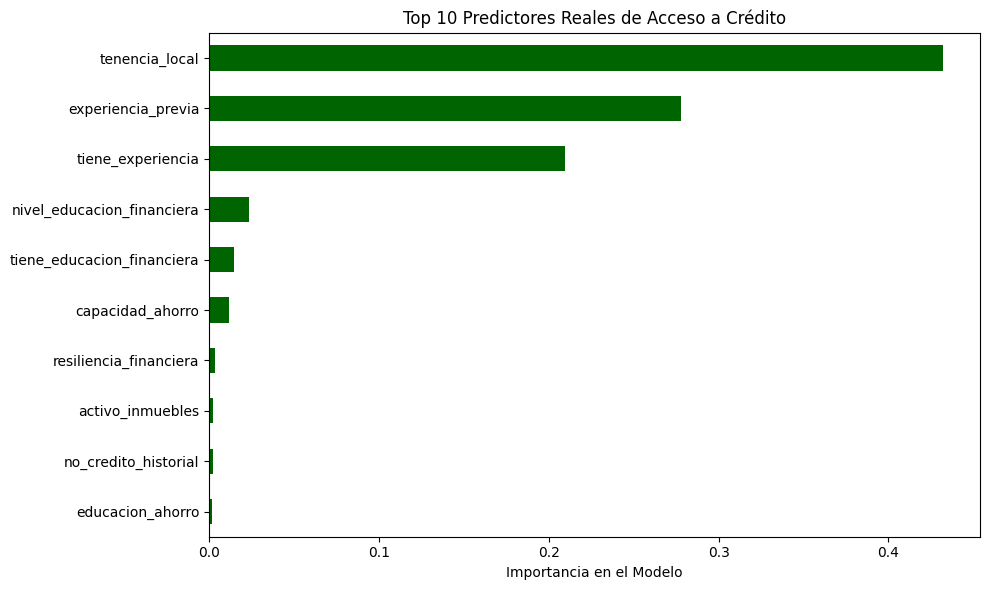

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# 1. Cargar el dataset maestro
df = pd.read_csv('FUSION EMICRON 2024 + GEIH 2023/dataset_ml_sin_indices.csv')


# 2. DEFINIR EL "MURO DE FUEGO" (Eliminación de Data Leakage)
# Estas variables contienen la respuesta o son consecuencia del crédito. 
# Si las dejamos, el modelo no aprende, solo "copia".
target = 'tiene_credito_formal'
columnas_leakage = [
    'num_creditos_formales', 'credito_bancario', 'credito_microfinanzas', 
    'credito_cooperativa', 'num_usos_credito', 'no_acceso_credito', 
    'acceso_credito', 'porcentaje_credito', 'opera_credito', 
    'ningun_producto_financiero', 'credito_capital_trabajo', 
    'credito_pago_deudas', 'credito_consumo', 'credito_emergencias'
]

# 3. Preparación de variables (X) y objetivo (y)
# Quitamos el target, los IDs y las variables que causan trampa
X = df.drop(columns=[target, 'nombre_departamento'] + columnas_leakage, errors='ignore')
y = df[target]

# Convertir variables categóricas si existen y llenar vacíos con la mediana
X = pd.get_dummies(X, drop_first=True)
X = X.fillna(X.median())

# 4. División con Estratificación (para mantener la proporción de micro-negocios con crédito)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Entrenamiento con Balanceo de Clases
# Usamos class_weight='balanced' porque en EMICRON hay pocos negocios con crédito
model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10, # Limitamos profundidad para evitar sobreajuste
    class_weight='balanced', 
    random_state=42
)
model.fit(X_train, y_train)

# 6. Evaluación de Resultados Corregidos
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("="*50)
print("RESULTADOS CORREGIDOS (SIN TRAMPA)")
print("="*50)
print(classification_report(y_test, y_pred))
print(f"AUC-ROC Real: {roc_auc_score(y_test, y_proba):.4f}")

# 7. Visualización de la Importancia de Variables Real
plt.figure(figsize=(10, 6))
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.nlargest(10).sort_values().plot(kind='barh', color='darkgreen')
plt.title('Top 10 Predictores Reales de Acceso a Crédito')
plt.xlabel('Importancia en el Modelo')
plt.tight_layout()
plt.show()